In [1]:
import pandas as pd

import networkx as nx

import os
import time

import matplotlib.pyplot as plt

import urbanaccess
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.utils import df_to_networkx
from urbanaccess.network import ua_to_networkx

%matplotlib inline

In [2]:
try:
    validation = True
    verbose = True
    # small bbox for testing purposes
    bbox = (-122.2821401059,37.7905877899,-122.245747894,37.8185277192)
    remove_stops_outsidebbox = True
    append_definitions = True
    gtfsfeed_path=None

    loaded_feeds = urbanaccess.gtfs.load.gtfsfeed_to_df(gtfsfeed_path,
                                                        validation,
                                                        verbose,
                                                        bbox,
                                                        remove_stops_outsidebbox,
                                                        append_definitions)
except:
    start_time = time.time()

    name = 'bart'
    url = 'http://www.bart.gov/dev/schedules/google_transit.zip'
    new_feed = {name: url}

    feeds.add_feed(new_feed)

    name = 'ac transit'
    url = 'https://api.actransit.org/transit/gtfs/download?token=2512B81107A09D2DC44895CDDC650D47'
    new_feed = {name: url}

    feeds.add_feed(new_feed)

    gtfsfeeds.download()
    print("RUN BLOCK CODE INSIDE try STATEMENT NOW")

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.11 seconds
--------------------------------
Processing GTFS feed: Bay Area Rapid Transit
     Successfully read: stops.txt with 47 record(s). Took 0.01 seconds
     Successfully read: routes.txt with 6 record(s). Took 0.00 seconds
     Successfully read: trips.txt with 2,513 record(s). Took 0.01 seconds
     Successfully read: stop_times.txt with 31,934 record(s). Took 0.10 seconds
     Successfully read: calendar.txt with 3 record(s). Took 0.00 seconds
     Successfully read: calendar_dates.txt with 50 record(s). Took 0.00 seconds
     Successfully read: agency.txt with 1 record(s). Took 0.00 seconds
The unique agency ID: bay_area_rapid_transit was generated using the name of the agency in the agency.txt file for tables: ['stops', 'routes', 'trips', 'stop_times', 'calendar', 'calendar_dates'].
Unique agency ID operation complet

     Successfully read: trips.txt with 15,069 record(s). Took 0.07 seconds
     Successfully read: stop_times.txt with 662,439 record(s). Took 1.50 seconds
     Successfully read: calendar.txt with 20 record(s). Took 0.00 seconds
     Successfully read: calendar_dates.txt with 15 record(s). Took 0.00 seconds
     Successfully read: agency.txt with 1 record(s). Took 0.00 seconds
The unique agency ID: ac_transit was generated using the name of the agency in the agency.txt file for tables: ['stops', 'routes', 'trips', 'stop_times', 'calendar', 'calendar_dates'].
Unique agency ID operation complete. Took 0.04 seconds.
Unique GTFS feed ID operation complete. Took 0.00 seconds.
Records:
         stop_id                         stop_name   stop_lat    stop_lon  \
0        0100060                 8th St:Portola Av  37.768814 -122.272992   
1        0100070                 8th St:Portola Av  37.768993 -122.272798   
2        0100110                 Atlantic Av:#1105  37.780272 -122.264015   
3 

In [3]:
transit_net = urbanaccess.gtfs.network.create_transit_net(
    gtfsfeeds_dfs=loaded_feeds,
    day='wednesday',
    timerange=['07:00:00', '10:00:00'],
    simplify=True)

osm_nodes, osm_edges = urbanaccess.osm.load.ua_network_from_bbox(bbox=bbox)

ua_network = urbanaccess.osm.network.create_osm_net(
    osm_edges=osm_edges,
    osm_nodes=osm_nodes,
    travel_speed_mph=3,
    network_type='drive') 

urbanaccess_nw = urbanaccess.network.integrate_network(
    urbanaccess_network=ua_network,
    headways=False)

--------------------------------
Running active service ID selection operation for agency: bay_area_rapid_transit
Processing active service_ids that match the specified parameters for trip selection...
     Selecting service_ids from calendar that are active on day: wednesday...
          1 service_id(s) were selected from calendar.
          Selecting service_ids from calendar_dates that are active on day: wednesday...
          1 service_id(s) were selected from calendar dates.
     Reconciling service_id(s) between calendar and calendar_dates based on exception_type... 
          Adding 1 service_id(s) to those found in calendar. Total active service_id(s): 2.
          Removing 0 service_id(s) from those found in calendar. Total active service_id(s): 2.
     In summary, active service IDs were derived from:
          2 out of 3 unique service_id(s) from calendar.
          2 out of 3 unique service_id(s) from calendar_dates.
2 active service_id(s) were found that match the specifie

# Evaluate graph type before instantiation

In [4]:
from urbanaccess.utils import get_node_relations_by_type

In [5]:
# self loops
sl = get_node_relations_by_type(edges_df=urbanaccess_nw.net_edges, 
                                nodes_df=urbanaccess_nw.net_nodes,
                                rel_type='self-loops')

Number of self loops found: 0


In [6]:
# multi edges
me = get_node_relations_by_type(edges_df=urbanaccess_nw.net_edges, 
                                nodes_df=urbanaccess_nw.net_nodes,
                                rel_type='multi-edges')

Number of parallel edges found: 30594


In [7]:
# multi-edges by node
me['52981390'].sum()

6

In [8]:
me['52981390']

from        to        
4182199938  52981390      2
52981390    53079265      2
            5478805480    2
dtype: int64

# Create NetworkX object type

### > MultiDigraph object type 

In [9]:
# look at the entire graph
multidi_graph = ua_to_networkx(urbanaccess_nw)

Converting UrbanAccess network to NetworkX graph...
UrbanAccess network to NetworkX graph conversion complete. Took 0.33 seconds.


In [10]:
type(multidi_graph)

networkx.classes.multidigraph.MultiDiGraph

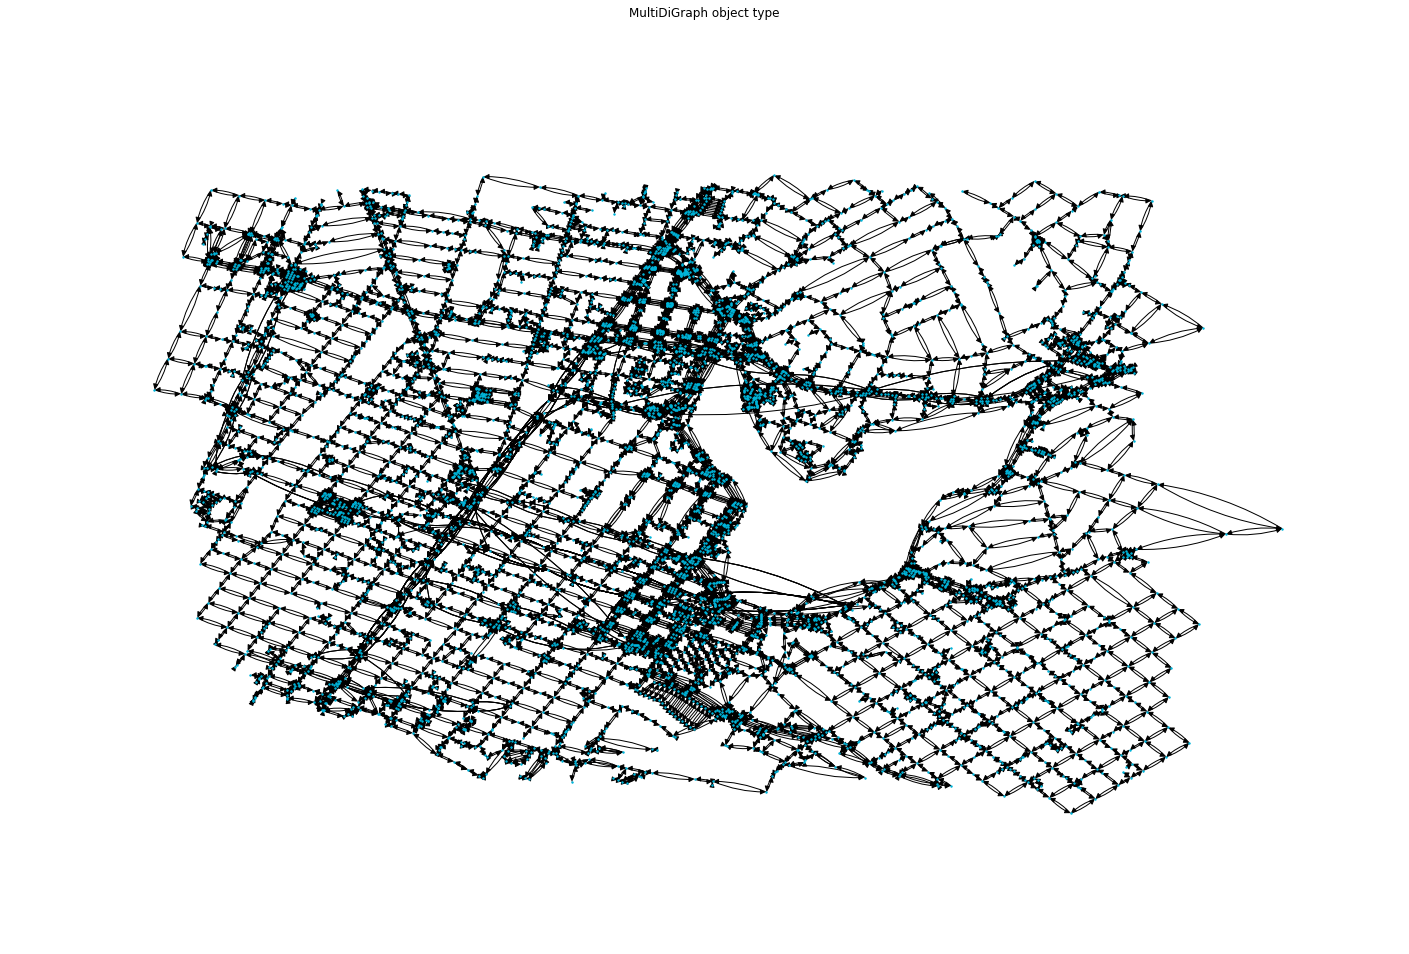

In [11]:
fig, ax = plt.subplots(figsize=(25,17))

pos = nx.get_node_attributes(multidi_graph,'coords')
nx.draw(multidi_graph, pos, with_labels=False, node_color='#00b4d9', 
        node_size=2, connectionstyle='arc3, rad = 0.1', ax=ax)
ax.set_title('MultiDiGraph object type');

In [12]:
from urbanaccess.utils import network_degree_stats

In [13]:
network_degree_stats(nx_graph=multidi_graph)

{'sum': 30594, 'mean': 6.0}

### Multigraph object type 

In [14]:
multi_graph = ua_to_networkx(urbanaccess_nw,  is_directed = False)

Converting UrbanAccess network to NetworkX graph...
UrbanAccess network to NetworkX graph conversion complete. Took 0.56 seconds.


In [15]:
type(multi_graph)

networkx.classes.multigraph.MultiGraph

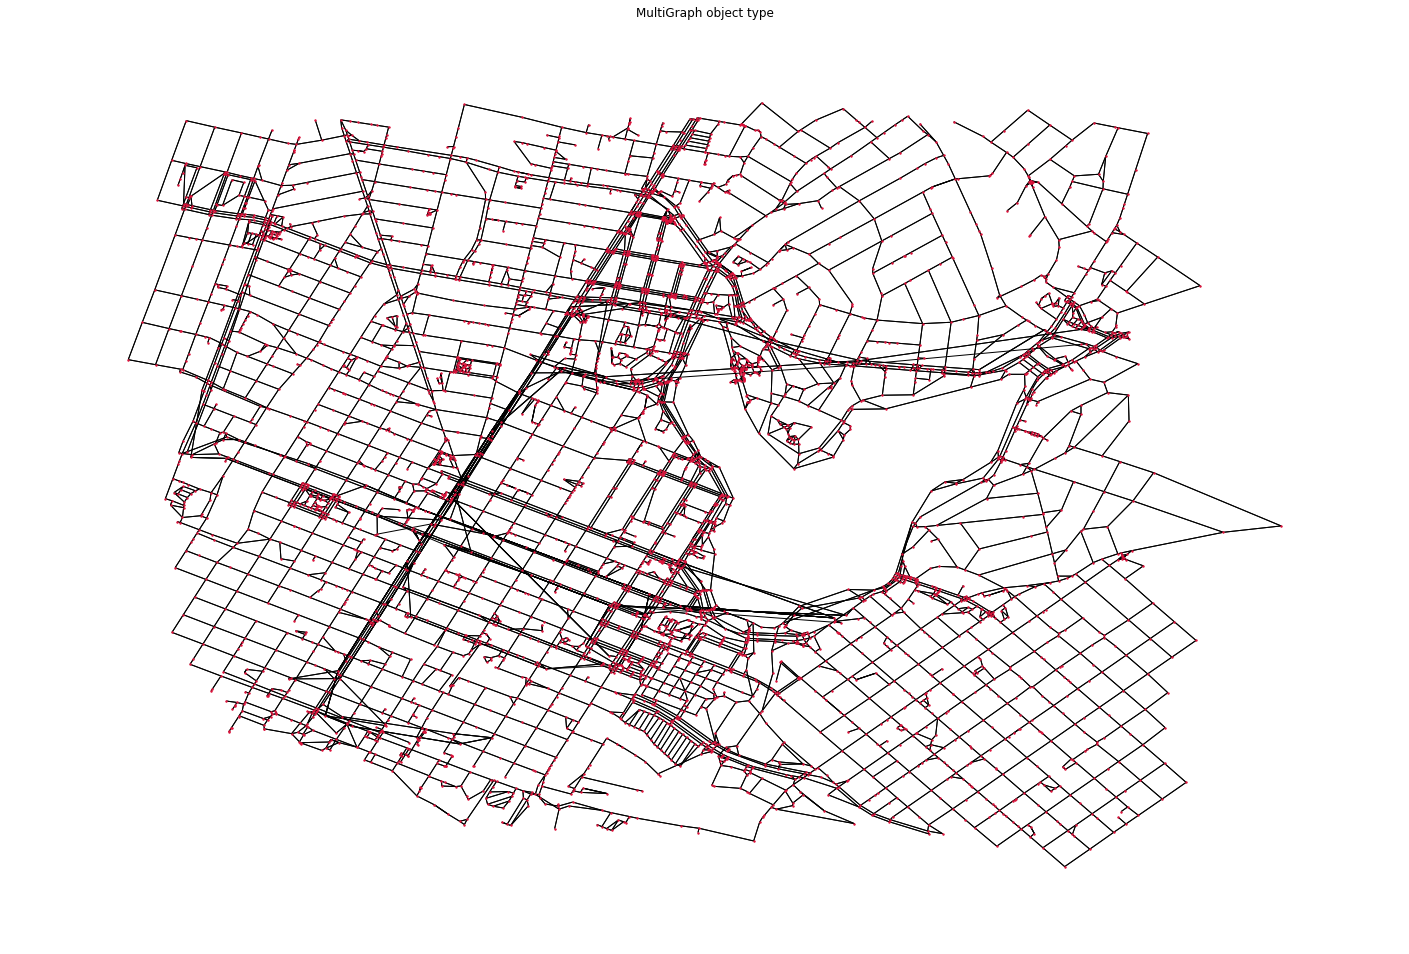

In [16]:
fig, ax = plt.subplots(figsize=(25,17))

pos = nx.get_node_attributes(multi_graph,'coords')
nx.draw(multi_graph, pos, with_labels=False, node_color='#dc143c', 
        node_size=2, connectionstyle='arc3, rad = 0.1', ax=ax)
ax.set_title('MultiGraph object type');

In [17]:
network_degree_stats(nx_graph=multidi_graph)

{'sum': 30594, 'mean': 6.0}

##  Additional network metrics 

* **Degree centrality**

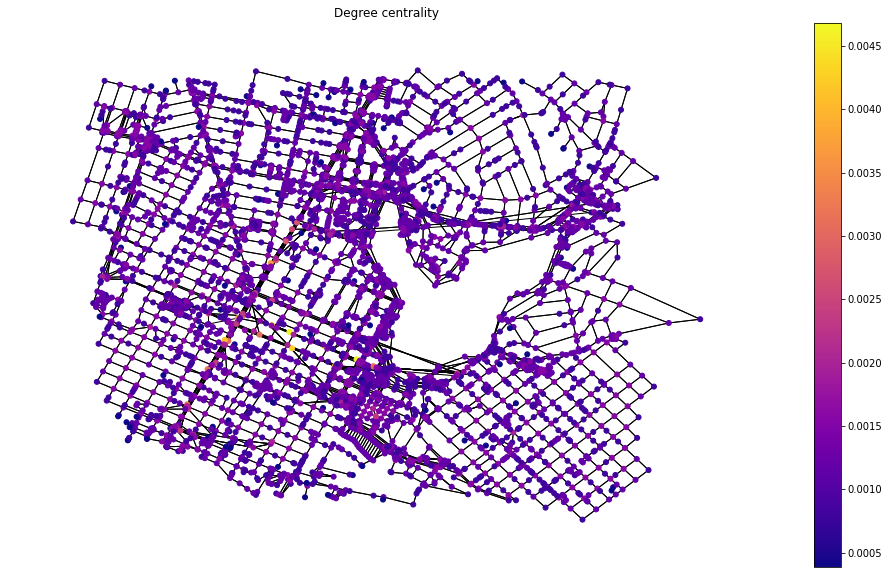

In [18]:
fig, ax = plt.subplots(figsize=(17,10))

pos = nx.get_node_attributes(multi_graph,'coords')
degree_centrality = nx.degree_centrality(multi_graph)

net_nodes = nx.draw_networkx_nodes(multi_graph, 
                                   pos, 
                                   node_size=25, 
                                   cmap=plt.cm.plasma, 
                                   node_color=list(degree_centrality.values()),
                                   nodelist=degree_centrality.keys())

edges = nx.draw_networkx_edges(multi_graph, pos)

plt.colorbar(net_nodes)
ax.set_axis_off()
ax.set_title('Degree centrality');

In [19]:
max(degree_centrality, key=degree_centrality.get)

15

In [20]:
degree_centrality[15]

0.0046792747124195745

In [21]:
nx_nodes_from_str_id = dict(zip(urbanaccess_nw.net_nodes.id,urbanaccess_nw.net_nodes.index))
nx_nodes_from_int_id = dict(zip(urbanaccess_nw.net_nodes.index,urbanaccess_nw.net_nodes.id))

In [22]:
nx_nodes_from_int_id[15]

'1000490_ac_transit'

In [23]:
# 0.4% of all possible connections in the network
multi_graph.degree[15]/(multi_graph.number_of_nodes()-1)

0.004679274712419575

In [24]:
node_id = nx_nodes_from_int_id[15]
node_dg = multi_graph.degree[15]
print("Node {} is connected with {} nodes, representing the highest connectivity value.".format(node_id, node_dg))

Node 1000490_ac_transit is connected with 24 nodes, representing the highest connectivity value.


* **Shortest path routing**

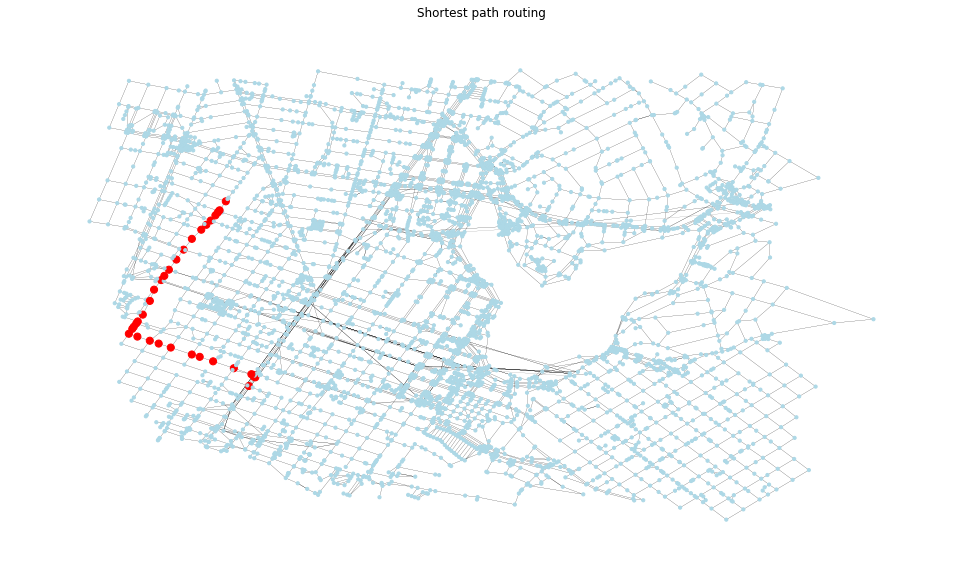

In [25]:
# weighting paths by distance to determine the shortest routing for a given nodes pair
shortest_path_nodes = nx.shortest_path(multi_graph, source=110, target=115, weight='distance')
node_colors = ["red" if n in shortest_path_nodes else "lightblue" for n in multi_graph.nodes()]
node_sizes = [50 if n in shortest_path_nodes else 10 for n in multi_graph.nodes()]

fig, ax = plt.subplots(figsize=(17,10))

net_nodes = nx.draw_networkx_nodes(multi_graph, 
                                   pos, 
                                   node_size=node_sizes, 
                                   node_color=node_colors)

edges = nx.draw_networkx_edges(multi_graph, pos, width=0.1)

ax.set_axis_off()
ax.set_title('Shortest path routing');

* **Betweenness centrality**

In [26]:
from urbanaccess.utils import from_parallel_to_single_edges

# you may want to go from multi to simple edges to get specific metrics
G = from_parallel_to_single_edges(nx_graph=multidi_graph, weighted_connection=False, use_average_weights=False)
type(G)

networkx.classes.graph.Graph

In [27]:
btwn_centrality = nx.betweenness_centrality(G)

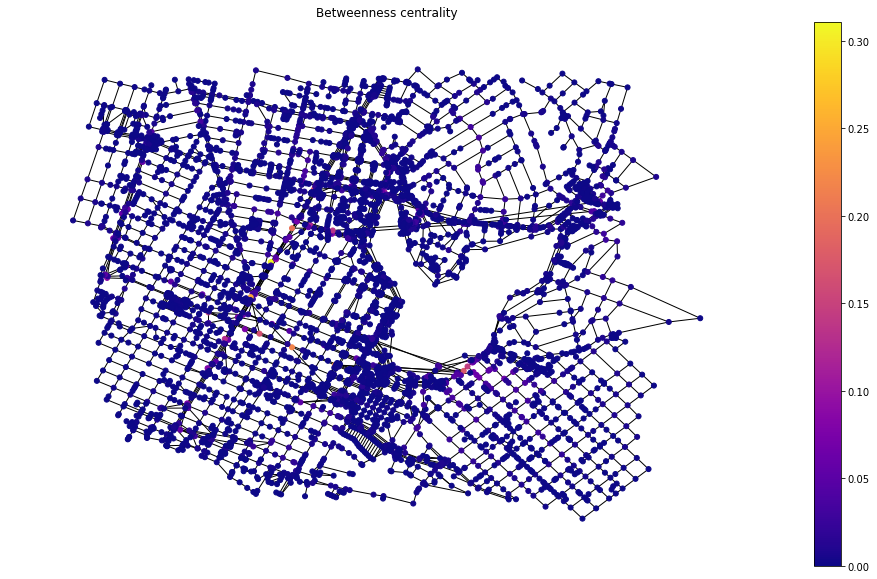

In [28]:
fig, ax = plt.subplots(figsize=(17,10))

net_nodes = nx.draw_networkx_nodes(G, 
                                   pos, 
                                   node_size=25, 
                                   cmap=plt.cm.plasma, 
                                   node_color=list(btwn_centrality.values()),
                                   nodelist=btwn_centrality.keys())

edges = nx.draw_networkx_edges(G, pos)

plt.colorbar(net_nodes)
ax.set_axis_off()
ax.set_title('Betweenness centrality');

In [29]:
max(btwn_centrality, key=btwn_centrality.get)

102

In [30]:
nx_nodes_from_int_id[102]

'9902070_ac_transit'

In [31]:
max_btwn_cen_n = nx_nodes_from_int_id[102]
max_btwn_cen_v = round(btwn_centrality[102]*100,2)

print('{}% of shortest paths in the net go trough the node {}'.format(max_btwn_cen_v, max_btwn_cen_n))

31.05% of shortest paths in the net go trough the node 9902070_ac_transit
